In [26]:
# Import stuff
from pandas import DataFrame, read_csv

from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.base import Bunch
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl.model import GLM
from nipype.interfaces.fsl.maths import TemporalFilter
from nipype.algorithms.confounds import CompCor
from nipype.interfaces.afni.model import Deconvolve, Remlfit

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# Set study variables
analysis_home = '/data/perlman/moochie/user_data/CamachoCat/ChEC/fmri_proc'
templates_dir = '/data/perlman/moochie/user_data/CamachoCat/Aggregate_anats/templates'
raw_dir = analysis_home + '/raw'
preproc_dir = analysis_home + '/preproc'
firstlevel_dir = analysis_home + '/subjectlevel'
secondlevel_dir = analysis_home + '/grouplevel'
workflow_dir = analysis_home + '/workflows'
affect_ratings = analysis_home + '/misc/ratings_20200427.csv'

gm_mask = templates_dir + '/lcbd_template_2mm_gm.nii.gz'

subject_info = read_csv(analysis_home + '/misc/subjectinfo.csv', index_col=None)
#subjects_list = subject_info['SubjID'].tolist()
subjects_list = ['1000','1001','1002','1006','1007','1008','1009','1011','1012','1015','1016','1017']

# data collection specs
TR = 0.8 #in seconds
duration= 1284

In [27]:
# Select subjects list
infosource = Node(IdentityInterface(fields=['subjid']),
                  name='infosource')
infosource.iterables = [('subjid', subjects_list)]

# Pull files
file_template = {'preproc_func': preproc_dir + '/fully_processed_func/{subjid}/lomo_func.nii.gz'}
selectfiles = Node(SelectFiles(file_template), name='selectfiles')

# Sink data of interest (mostly for QC)
substitutions = [('_subjid_', '')] #output file name substitutions
datasink = Node(DataSink(base_directory = firstlevel_dir,
                        container = firstlevel_dir,
                        substitutions = substitutions), 
                name='datasink')

In [28]:
## Timing handling nodes
def affectiveTiming(ratings_file,TR, duration):
    from nipype import logging, config
    config.enable_debug_mode()
    logging.update_logging(config)
    import numpy as np
    from pandas import read_csv
    from os.path import abspath 
    import matplotlib.pyplot as plt
    
    def hrf(time):
        from scipy.stats import gamma
        peak = gamma.pdf(time, 6) # 6-second peak
        undershoot = gamma.pdf(time, 12)# 12-sec undershoot
        hrf_vals = peak-0.35*undershoot
        return(hrf_vals)
    
    tr_timing = np.arange(0,duration,TR)
    hrf_tr = hrf(tr_timing)
    
    ratings = read_csv(ratings_file, index_col=0)
    regress_matrix = np.zeros((1605,2))
    regress_matrix[:,0] = np.convolve(ratings['negative'],hrf_tr)[:1605]
    regress_matrix[:,1] = np.convolve(ratings['positive'],hrf_tr)[:1605]
    
    design_file_name = 'matrix.txt'
    np.savetxt(design_file_name, regress_matrix)
    design_file = abspath(design_file_name)
    
    return(design_file)

In [29]:
# create the design file
make_design = Node(Function(input_names=['ratings_file', 'TR', 'duration'], 
                            output_names=['design_file'],
                            function=affectiveTiming), name='make_design')
make_design.inputs.TR = TR
make_design.inputs.duration = duration
make_design.inputs.ratings_file = affect_ratings

#run the GLM
estmodel = Node(GLM(dat_norm = True,
                    out_file = 'betas.nii.gz', 
                    out_cope='cope.nii.gz',
                    out_t_name = 'tstat.nii.gz', 
                    mask=gm_mask), 
                name= 'estmodel')

In [ ]:
L1workflow = Workflow(name='L1workflow_univariate')
L1workflow.connect([(infosource,selectfiles,[('subjid','subjid')]),
                    (selectfiles,estmodel,[('preproc_func','in_file')]),
                    
                    (make_design, estmodel, [('design_file','design')]),
                    (estmodel, datasink, [('out_cope','copes')]),
                    (estmodel, datasink, [('out_t','tstats')]),
                    (estmodel, datasink, [('out_file','betas')])
                   ])
L1workflow.base_dir = workflow_dir
#L1workflow.write_graph(graph2use='flat')
L1workflow.run('MultiProc', plugin_args={'n_procs': 6, 'memory_gb':10})

200427-19:47:23,382 nipype.workflow DEBUG:
	 (L1workflow_univariate.infosource, L1workflow_univariate.selectfiles): No edge data
200427-19:47:23,383 nipype.workflow DEBUG:
	 (L1workflow_univariate.infosource, L1workflow_univariate.selectfiles): new edge data: {'connect': [('subjid', 'subjid')]}
200427-19:47:23,384 nipype.workflow DEBUG:
	 (L1workflow_univariate.selectfiles, L1workflow_univariate.estmodel): No edge data
200427-19:47:23,385 nipype.workflow DEBUG:
	 (L1workflow_univariate.selectfiles, L1workflow_univariate.estmodel): new edge data: {'connect': [('preproc_func', 'in_file')]}
200427-19:47:23,385 nipype.workflow DEBUG:
	 (L1workflow_univariate.make_design, L1workflow_univariate.estmodel): No edge data
200427-19:47:23,386 nipype.workflow DEBUG:
	 (L1workflow_univariate.make_design, L1workflow_univariate.estmodel): new edge data: {'connect': [('design_file', 'design')]}
200427-19:47:23,387 nipype.workflow DEBUG:
	 (L1workflow_univariate.estmodel, L1workflow_univariate.datasink

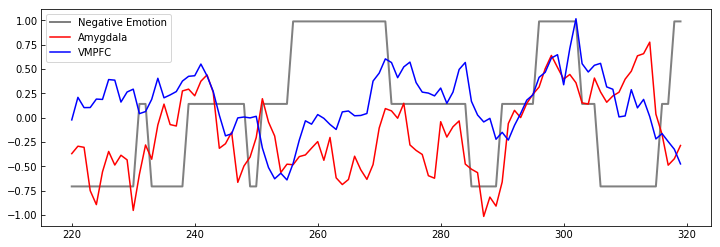

In [22]:
from sklearn.preprocessing import StandardScaler
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt

emotion = read_csv('/home/camachocm2/Analysis/ChEC/fmri_proc/misc/affect_tense_neg.csv',index_col=0)
std_emo = StandardScaler()
std_emo.fit(emotion)
std_emo_ts = std_emo.fit_transform(emotion)
std_emo_ts = std_emo_ts * 0.7 - .2
std_emotion = DataFrame(data=std_emo_ts,columns=emotion.columns, index=emotion.index)


from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
from glob import glob

files = glob('/home/camachocm2/Analysis/ChEC/fmri_proc/subjectlevel/timeseries_file/*/atlas_timeseries.csv')

dfs = []
for file in files:
    dfs.append(read_csv(file,index_col=0))

comb_df = concat(dfs)
avg_child = comb_df.groupby(comb_df.index).mean()

region_name = ['VMPFC','dacc','msfg','mfg','amyg']
region_label = ['label116','label27.0','label182.0','label273.0','label345.0']

i=0

ax = plt.figure(figsize=(12,4))
plt.tick_params(direction='in')
plt.plot(std_emotion.index[220:320],std_emotion['tense'][220:320],c='gray', label='Negative Emotion', linewidth=2)
plt.plot(std_emotion.index[220:320],avg_child['label345'][220:320],c='r', label='Amygdala')
plt.plot(std_emotion.index[220:320],avg_child[region_label[i]][220:320],c='b', label=region_name[i])
plt.legend()
plt.savefig('/home/camachocm2/Analysis/ChEC/pilot_results/avg_amyg_%s.svg' % region_name[i])
plt.show()
plt.close()


In [ ]:
sub_combined = concat([std_emotion,std_timeseries_df], axis=1)
import numpy as np
corr_mat = sub_combined.corr()
corr_mat[corr_mat==1] = np.nan
corr_mat2 = corr_mat[corr_mat>0.3]
corr_mat2[corr_mat<-0.3] = corr_mat
plt.figure()
plt.matshow(corr_mat2)
plt.legend()
plt.show()
plt.close()
#corr_mat.to_csv('1003_corr_mat.csv')

import seaborn as sns
#sns.set(context='talk')
fig, ax = plt.subplots(figsize=(20,18))
sns.heatmap(corr_mat2, fmt='d')